# Reinforcement Learning - Sutton and Barto
# Exercise 4.7

Policy Iteration

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats

from jackcarrental_non_linear import jack_car_rental

# Initialize Environment

In [2]:
env = jack_car_rental()

## Initialization of the policy

20 x 20 states (20 cars on each lot)
6 actions (asking from -5 to 5 cars)

In [3]:
policy_probs = np.full((21, 21, 11),0)
for row in range(21):
    for col in range(21):
        policy_probs[(row, col, 5)] = 1
#print(f"{policy_probs}")

In [4]:
def policy(state):
    return policy_probs[state].argmax()

In [5]:
def plot_policy(policy_probs):
    if policy_probs is not None:
        max_prob_actions = policy_probs.argmax(axis=-1)
        plt.figure()
        plt.title("Policy")
        plt.ylabel("Cars at Location 1")
        plt.xlabel("Cars at Location 2")
        plt.imshow(max_prob_actions - env.max_transfer, origin='lower',
                   vmin=-env.max_transfer, vmax=+env.max_transfer)
        plt.colorbar()

In [6]:
# Define Plot Function

In [7]:
plt.close('all')

In [8]:
def plot_values(values):
        if values is not None:
            plt.figure()
            plt.title("Value Function")
            plt.ylabel("Cars at Location 1")
            plt.xlabel("Cars at Location 2")
            plt.imshow(values, origin='lower')
            plt.colorbar()

In [9]:
def plot_results(policy_probs, values):
    plot_policy(policy)
    plot_values(values)

In [10]:
def plot_bars(title, ylabel, xlabel, z_data):
    plt.figure()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    z0 = plt.bar(z_data[0][0], z_data[0][1], label=z_data[0][2])
    z1 = plt.bar(z_data[1][0], z_data[1][1], label=z_data[1][2])
    plt.legend()

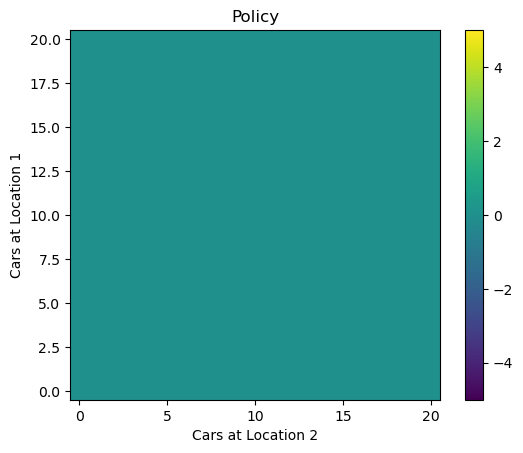

In [11]:
plot_policy(policy_probs)

### Define value table *V(s)* 

In [12]:
state_values = np.zeros(shape=(21,21))

#### Plot *V(s)*

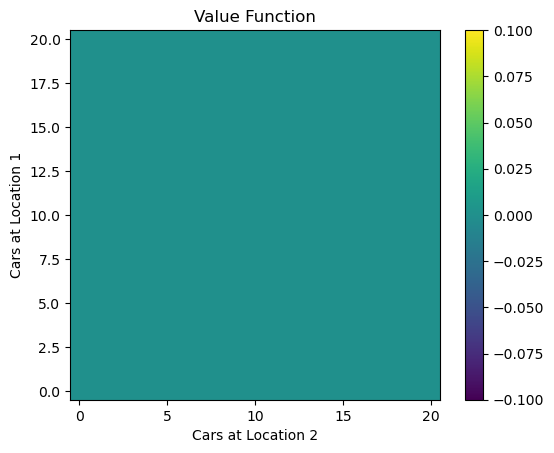

In [13]:
plot_values(state_values)

# Running a 365 day scenario

In [14]:
def run_scenario(days=365):
    rewards = np.zeros(days, dtype=int)
    actions = np.zeros(days, dtype=int)
    states = np.zeros(days, dtype=tuple)
    cars_rented = np.zeros(days, dtype=tuple)
    cars_returned = np.zeros(days, dtype=tuple)
    
    state = env.reset()
    
    states[0] = state
    
    for day in tqdm(range(days-1)):
        action = policy(state)
        next_state, reward, rented_cars, returned_cars = env.step(action) 
        states[day + 1] = next_state
        rewards[day + 1] = reward
        actions[day + 1] = action
        cars_rented[day + 1] = rented_cars
        cars_returned[day + 1] = returned_cars
        
        state = next_state
        
    return states, actions, rewards, cars_rented, cars_returned

In [15]:
days = 365
states, actions, rewards, cars_requested, cars_returned = run_scenario(days)

100%|█████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 12230.35it/s]


# Plot Scenario

In [16]:
def plot_scenario(days):
    matplotlib.rcParams['figure.figsize'] = [10, 5]

    cars_in_location1 = []
    cars_in_location2 = []

    for index in range(len(states)):
        cars_in_location1.append(states[index][0])

    for index in range(len(states)):
        cars_in_location2.append(states[index][1])

    z_data = [[range(days), cars_in_location1, "Location 1"],[range(days), cars_in_location2, "Location 2"]]

    plot_bars("Jack's Random Year", "Number of Cars", "Days", z_data) 

    plt.figure()
    plt.title("Histogram of Revenue vs Transfer")
    plt.ylabel("Revenue")
    plt.xlabel("Transfer (1 -> 2)")
    z = plt.hist2d(actions - env.max_transfer, rewards, bins=[10, 6],
                   range=[[-env.max_transfer, +env.max_transfer], [-60, +60]])
    plt.colorbar()

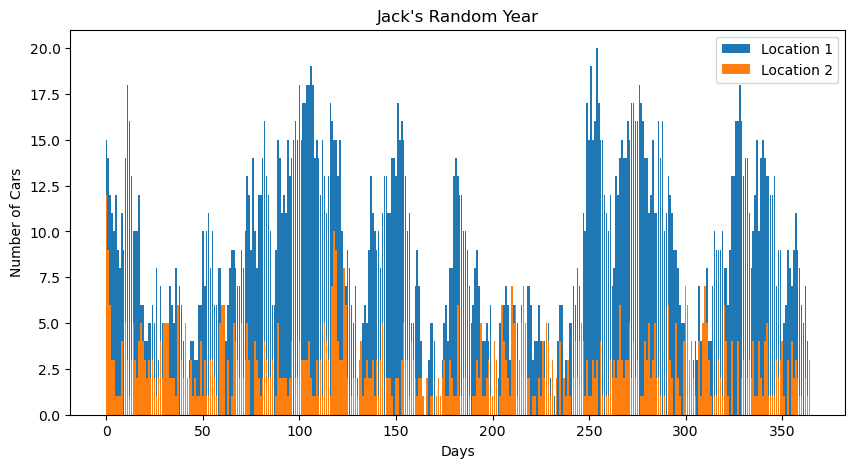

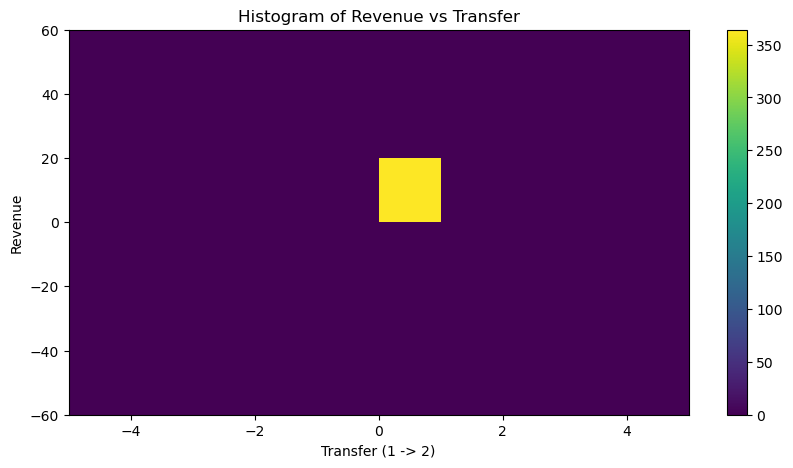

In [17]:
plot_scenario(days)

## Implement the Policy Iteration algorithm

</br>

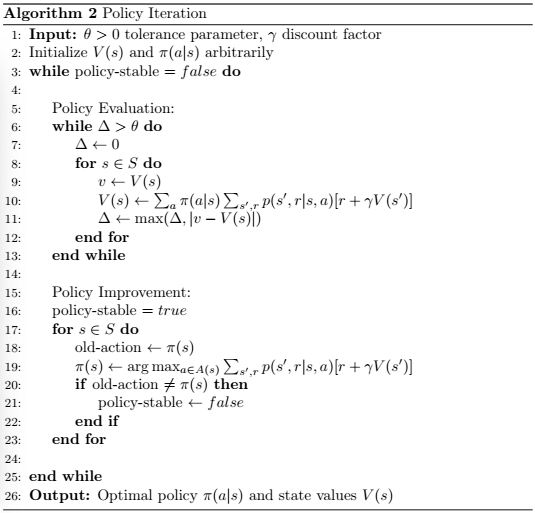

<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [18]:
env.reset()

(15, 3)

In [19]:
def policy_evaluation(policy_probs, state_values, theta=1e-5, gamma=0.9):
    delta = float("inf")
        
    while delta > theta:
        delta = 0
        
        for row in range(21):
            for col in range(21):
                
                old_value = state_values[(row,col)]
                new_value = 0.
                action_probabilities = policy_probs[(row,col)]
                state = (row,col)
                
                for action,prob in enumerate(action_probabilities):
                    
                    # expected_return gives the sum of p(s',r|s,a)*[r + gamma*V(s')] for all possible next states and returns
                    expected_return = env.expected_return(state_values, action, state, gamma)
                    new_value += prob * expected_return
                    
                state_values[(row,col)] = new_value
                
                delta = max(delta, abs(old_value - new_value))

        #print(f"Delta: {delta}")
                    

In [20]:
def policy_improvement(policy_probs, state_value, gamma=0.9):
    policy_stable = True
    
    for row in range(21):
        for col in range(21):
            state = (row, col) 

            old_action = policy(state)          
            max_qsa = float("-inf")
            
            action_probs = np.zeros(11)
            
            for action in range(11):
                qsa = env.expected_return(state_values, action, state, gamma)
                    
                if qsa > max_qsa:
                    new_action = action
                    max_qsa = qsa
                
                    action_probs = np.zeros(11)
                    action_probs[new_action] = 1.
                    policy_probs[state] = action_probs

                #print(f"State: {state}, action: {action}, new_action: {new_action}, Probs: {policy_probs[state]}")
            if old_action != new_action:
                policy_stable = False
    
    return policy_stable

In [21]:
def policy_iteration(policy_probs, state_values, theta=1e-5, gamma=0.9):
    policy_stable = False
    policy_iteration = 1
    
    while not policy_stable:
        
        print(f"Policy Iteration: {policy_iteration}")
        
        policy_evaluation(policy_probs, state_values, theta, gamma)
        print(f"Policy Evaluaton iteration {policy_iteration} finished")
        plot_values(state_values)
        
        policy_stable = policy_improvement(policy_probs, state_values, gamma)
        print(f"Policy improvement iteration {policy_iteration} finished")
        plot_policy(policy_probs)
        
        policy_iteration += 1

Policy Iteration: 1
Policy Evaluaton iteration 1 finished
Policy improvement iteration 1 finished
Policy Iteration: 2
Policy Evaluaton iteration 2 finished
Policy improvement iteration 2 finished
Policy Iteration: 3
Policy Evaluaton iteration 3 finished
Policy improvement iteration 3 finished
Policy Iteration: 4
Policy Evaluaton iteration 4 finished
Policy improvement iteration 4 finished


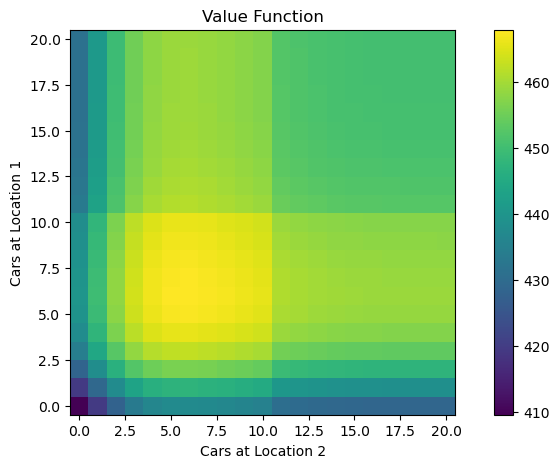

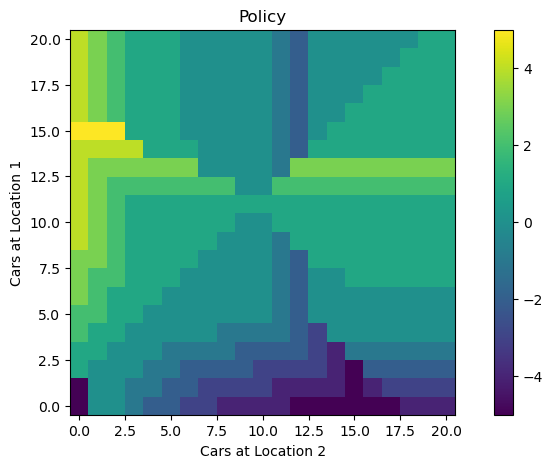

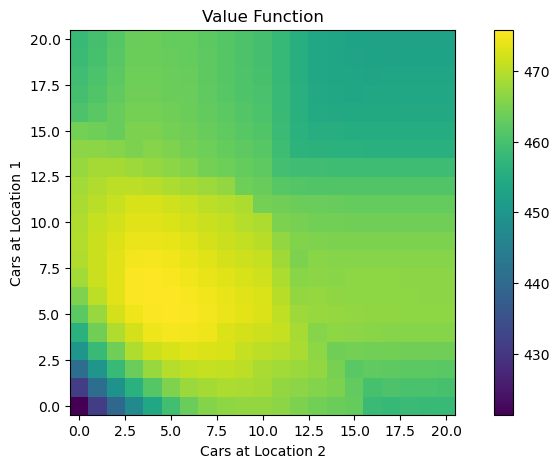

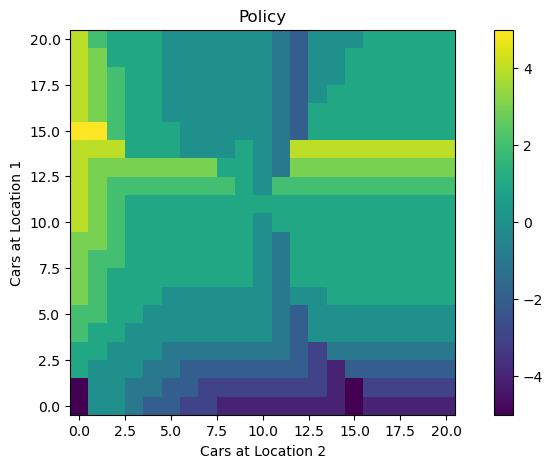

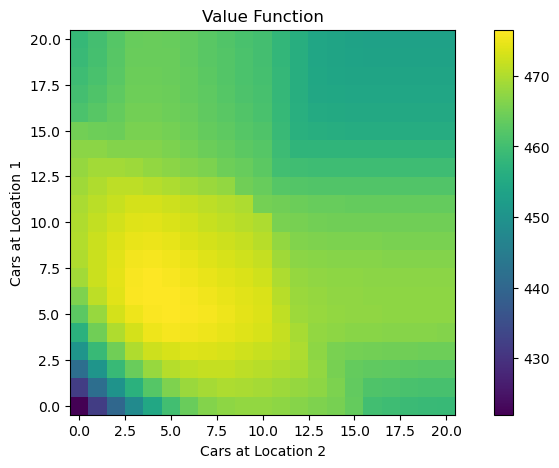

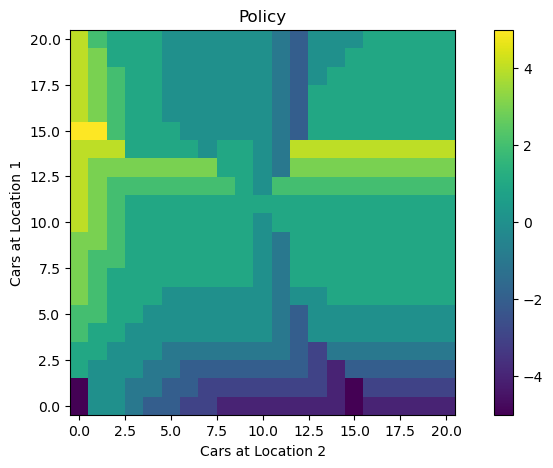

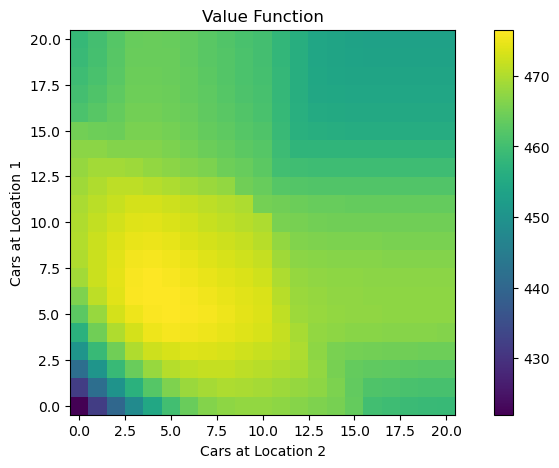

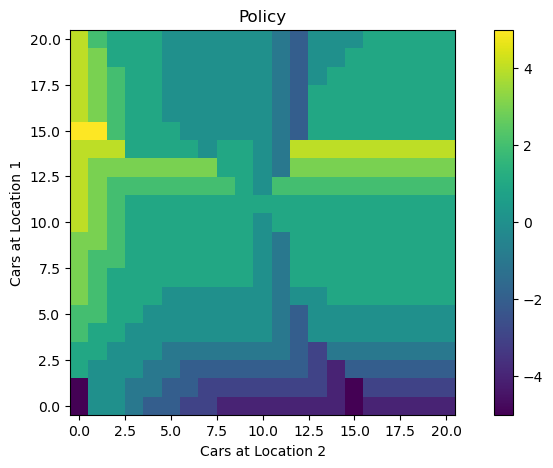

In [22]:
policy_iteration(policy_probs, state_values)